In [ ]:
import os
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.utils as vutils
import ignite
from ignite.engine import Engine, Events
import ignite.distributed as idist
import logging
from ignite.metrics import FID, InceptionScore
from torchmetrics.classification import BinaryHingeLoss
from torch.autograd import grad as torch_grad
from torch.autograd import Variable
import copy 

Loading up loggers, setting seed for reproducibility, using ignite for more readable code

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Setting parameters, source: https://arxiv.org/pdf/1511.06434.pdf%C3

In [ ]:
batch_size=32
learning_rate=0.001 #0.0002
epochs=200
z=512
in_channels=3
ec=2
rsz=transforms.Resize((4,4))
cat=10
path_to_progress_img="./pprogress/"
path_to_weights="./pweights/"
path_to_images="./img_align_celeba/"

In [ ]:
import numpy
dataset=datasets.ImageFolder(
    path_to_images,
    transform=transforms.Compose([
        transforms.Resize((128,128)),
        #transforms.RandomCrop((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5063,0.4258, 0.3831], std=[0.3107,0.2904,0.2897], inplace=True),
    ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True,num_workers=2)

In [ ]:
class EqualizedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(EqualizedConv2d, self).__init__()

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))

        fan_in = in_channels * kernel_size * kernel_size
        self.scale = (2 / fan_in) ** 0.5

        self.stride = stride
        self.padding = padding

    def forward(self, x):
        weight = self.weight * self.scale
        x = F.conv2d(x, weight, bias=self.bias, stride=self.stride, padding=self.padding)
        return x

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)
    
class UpscaleBlock(nn.Module):
    def __init__(self, input_channel, out_channel, pixel_norm=True):
        super(UpscaleBlock, self).__init__()
        self.conv1 = EqualizedConv2d(input_channel, out_channel,padding="same")
        self.conv2 = EqualizedConv2d(out_channel, out_channel,padding="same")
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()
        self.use_pn = pixel_norm
        

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

Source: https://arxiv.org/pdf/1511.06434.pdf%C3

In [ ]:
class Generator(nn.Module):
      def __init__(self,z_dim):
            super(Generator, self).__init__()
            self.filters=[512,256,128,64,32]
            self.First = nn.Sequential(
                PixelNorm(),
                nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
                nn.LeakyReLU(0.2),
                PixelNorm(),
                EqualizedConv2d(in_channels, 512, kernel_size=3, stride=1, padding="same"),
                nn.LeakyReLU(0.2),
                PixelNorm(),
            )
            self.toRGB = torch.nn.ModuleList([
                EqualizedConv2d(512, 3, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(256, 3, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(128, 3, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(64, 3, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(32, 3, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(16, 3, kernel_size=1, stride=1, padding="same"),
            ])
            self.blocks=torch.nn.ModuleList([
                UpscaleBlock(512,256),
                UpscaleBlock(256,128),
                UpscaleBlock(128,64),
                UpscaleBlock(64,32),
                UpscaleBlock(32,16),
            ])
      def forward(self, x,stage,fade):
            img=self.First(x)
            if stage ==0:
                return self.toRGB[stage](img)
            for i in range(stage):
                up=F.interpolate(img, scale_factor=2, mode="nearest")
                img= self.blocks[i](up)
            
            last_up=self.toRGB[stage-1](up)
            last_img=self.toRGB[stage](img)
            return self.fade_in(fade,last_up,last_img)
      
      def fade_in(self, alpha, upscaled, generated):
            return alpha * generated + (1 - alpha) * upscaled

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.Last = nn.Sequential(
                EqualizedConv2d(513, 512, kernel_size=3, stride=1, padding="same"),
                nn.LeakyReLU(0.2),
                EqualizedConv2d(512, 1, kernel_size=4, stride=1, padding=0),
        )
        self.fromRGB = torch.nn.ModuleList([
                EqualizedConv2d(3, 512, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(3, 256, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(3, 128, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(3, 64, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(3, 32, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(3, 16, kernel_size=1, stride=1, padding="same"),
                EqualizedConv2d(3, 8, kernel_size=1, stride=1, padding="same"),
            ])
        self.blocks=torch.nn.ModuleList([
                UpscaleBlock(256,512,pixel_norm=False),
                UpscaleBlock(128,256,pixel_norm=False),
                UpscaleBlock(64,128,pixel_norm=False),
                UpscaleBlock(32,64,pixel_norm=False),
                UpscaleBlock(16,32,pixel_norm=False),
                UpscaleBlock(8,16,pixel_norm=False),
            ])
        self.leaky = nn.LeakyReLU(0.2)
        self.pool=nn.AvgPool2d(2,2)
        self.zoz=[4,3,2,1,0]
    def forward(self,x,stage,fade):
        if stage ==0:
            val=self.leaky(self.fromRGB[stage](x))
            val=self.minibatch_std(val)
            return self.Last(val)
        val=self.leaky(self.fromRGB[stage+1](x)) #128,8,8
        down=self.leaky(self.fromRGB[stage](self.pool(x))) #256,4,4
        val=self.pool(self.blocks[stage](val)) #256,4,4
        val=self.fade_in(fade,down,val)
        
        for i in reversed(range(stage)):
            val= self.blocks[i](val) #512,4,4
            if i!=0:
                val=self.pool(val) #512,2,2
        
        val=self.minibatch_std(val)
        return self.Last(val)
    
    def fade_in(self, alpha, upscaled, generated):
        return alpha * generated + (1 - alpha) * upscaled
    
    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3]))
        return torch.cat([x, batch_statistics], dim=1)

In [ ]:
# gen=idist.auto_model(Generator(512))
# dis=idist.auto_model(Discriminator())
# gens= copy.deepcopy(gen)
gen=Generator(512).to(device)
dis=Discriminator().to(device)
gens= copy.deepcopy(gen)

In [ ]:
def exp_mov_avg(Gs, G, alpha=0.999, global_step=999):
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(Gs.parameters(), G.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)
def hypersphere(z, radius=1):
    return z * radius / z.norm(p=2, dim=1, keepdim=True)

In [ ]:
lossFun=nn.BCEWithLogitsLoss(reduction="mean")
fixed_noise = hypersphere(torch.randn(32, z, 1, 1,device=device))
#fixed_labels=torch.randint(low=0, high=cat,size=(32,1,1,1),device=device)
real_label = 1
fake_label = 0

In [ ]:
optimizerD = torch.optim.AdamW(dis.parameters(), lr=learning_rate*1,betas=(0, 0.99),weight_decay=0)
optimizerG = torch.optim.AdamW(gen.parameters(), lr=learning_rate*1,betas=(0, 0.99),weight_decay=0)

In [ ]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
            nn.init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
if (len(os.listdir(path_to_weights)) == 0):
        dis.apply(init_weights)
        gen.apply(init_weights)
        gens.apply(init_weights)
else:
        dis.load_state_dict(torch.load(path_to_weights+"dis_epoch_%d.pth" % 1,map_location=device))
        gen.load_state_dict(torch.load(path_to_weights+"gen_epoch_%d.pth" % 1,map_location=device))
        gens.load_state_dict(torch.load(path_to_weights+"gens_epoch_%d.pth" % 1,map_location=device))

Source: https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/

In [ ]:
lamb=10
n_crit=1
stage=0
fade=0
def gradient_penalty(real_data, generated_data,stage,fade):
        batch_size = real_data.size()[0]
        alpha = hypersphere(torch.rand(batch_size, 1, 1, 1,device=device))
        alpha = alpha.expand_as(real_data)
        if torch.cuda.is_available():
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if torch.cuda.is_available():
            interpolated = interpolated.cuda()

        prob_interpolated = dis(interpolated,stage,fade)

        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size(),device=device),
                               create_graph=True, retain_graph=True)[0]

        gradients = gradients.view(batch_size, -1)
        gradient_penalty = (((gradients.norm(2, dim=1) - 1) / 1) ** 2).mean() * lamb
        
        return gradient_penalty 

In [ ]:
counter=0
fade=0
stage=0
img_shape=(4,4)
passes=0
for epoch in range(epochs):
        if counter>1600000:
                stage+=1
                fade=0
                counter=0
                passes=0
                img_shape=tuple(2*x for x in img_shape)
                rsz=transforms.Resize(img_shape)
                batch_size
                if img_shape[0]>128:        
                        break
        passes+=1
        for i, data in enumerate(dataloader,0):
                dis.zero_grad()
                real=data[0].to(device)
                real=rsz(real)
                batch_size=real.size(0)
                counter+=batch_size
                fade=counter/800000 if counter<800000 else 1
                output = dis(real,stage,fade)
                noise = hypersphere(torch.randn(batch_size, z, 1, 1, device=device))
                fake = gen(noise,stage,fade)
                D_x = output.mean().item()
                D_G_z1 = torch.mean(dis(fake,stage,fade))

                grad_pen=gradient_penalty(real,fake,stage,fade)
                
                drift=(output ** 2).mean() *0.001

                dis_loss= D_G_z1 -  D_x + grad_pen + drift

                dis_loss.backward()
                optimizerD.step()

                if i % n_crit == 0:
                         optimizerG.zero_grad()
                         crit_fake=gen(noise,stage,fade)
                         gen_loss= - torch.mean(dis(crit_fake,stage,fade))
                         gen_loss.backward()
                         optimizerG.step()

                exp_mov_avg(gens,gen,.999,counter//batch_size)

                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f'
                % (epoch, epochs, i, len(dataloader),
                        dis_loss.item(), gen_loss.item(), D_x, D_G_z1))
                if i % 50 == 0:
                        fake = gens(fixed_noise,stage,fade).cpu()
                        vutils.save_image(fake.detach(),
                                '%s/fake_samples_epoch_%04d_stage_%2d.png' % (path_to_progress_img, passes,stage),
                    normalize=True)
        torch.save(gen.state_dict(), '%s/gen_epoch_%d.pth' % (path_to_weights, 1))
        torch.save(gens.state_dict(), '%s/gens_epoch_%d.pth' % (path_to_weights, 1))
        torch.save(dis.state_dict(), '%s/dis_epoch_%d.pth' % (path_to_weights, 1))

Source: https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

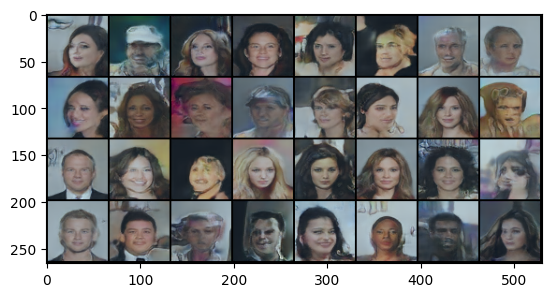

In [2]:
plt.imshow(Image.open("./pprogress/fake_samples_epoch_0008_stage_ 4.png"))

In [ ]:
!nvidia-smi